# Setup
This project requires Scikit-Learn ≥ 1.0.1:

In [1]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/training_linear_models` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Linear Regression
### The Normal Equation

In [4]:
import numpy as np

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) # column vector with 100 random values between 0 and 2
y = 4 + 3 * X + np.random.randn(m, 1) # To make the points scatter

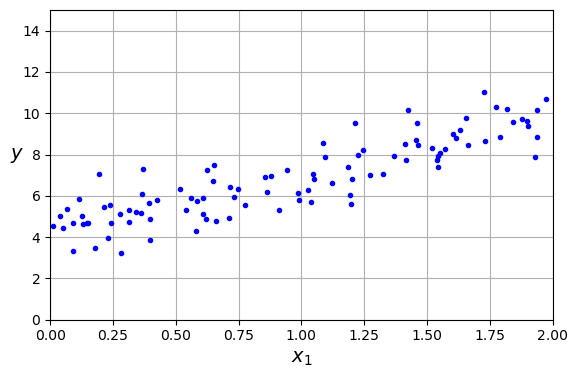

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("generated_data_plot")
plt.show()

In [6]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X) # to make the matrix shape compatible for multiplication by adding x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

theta_best

array([[4.21509616],
       [2.77011339]])

Now we can make predictions using this `theta_best` vector:

In [8]:
X_new = np.array([[0], [2]]) # Try to predict the y-values of these 2 X-values
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

Explanation: Using the parameters from `theta_best`, the equation is y = 4.21509616 + 2.77011339 * x. Hence we substitute the values 0 and 2 to get these 2 predicted y-values.

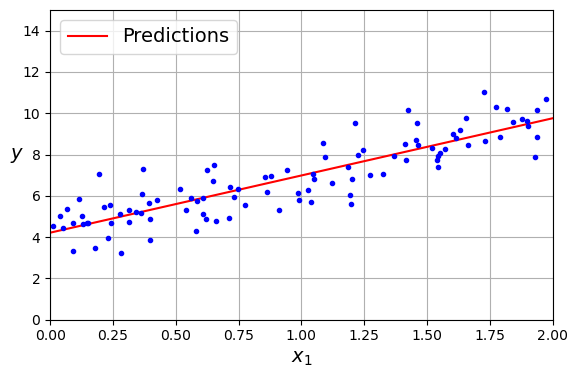

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
save_fig("linear_model_predictions_plot")

plt.show()

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [12]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The `LinearRegression` class is based on the `numpy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [13]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

Syntax: `linalg.lstsq(a, b, rcond='warn')` 
Computes the vector x that approximately solves the equation a @ x = b.
Since `X_new @ theta_best = y`, this returns `theta_best`.
This function computes $X^{+}y$ , where $X^{+}$
 is the pseudoinverse of $X$
 (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [15]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

# Gradient Descent
### Batch Gradient Descent

In [16]:
eta = 0.1 # learning rate
n_epochs = 1000
m = len(X_b) # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1) # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

The trained model parameters:

In [17]:
theta

array([[4.21509616],
       [2.77011339]])

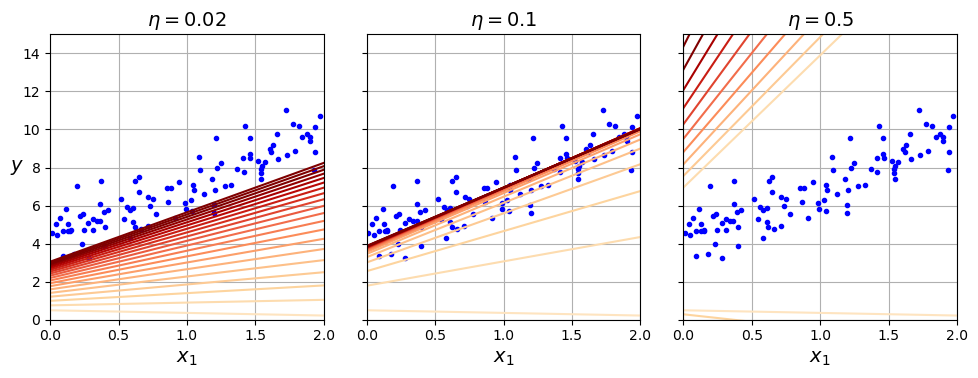

In [18]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
save_fig("gradient_descent_plot")
plt.show()

The figure shows the first 20 steps of gradient descent using 3 different learning rates.

### Stochastic Gradient Descent

In [19]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure

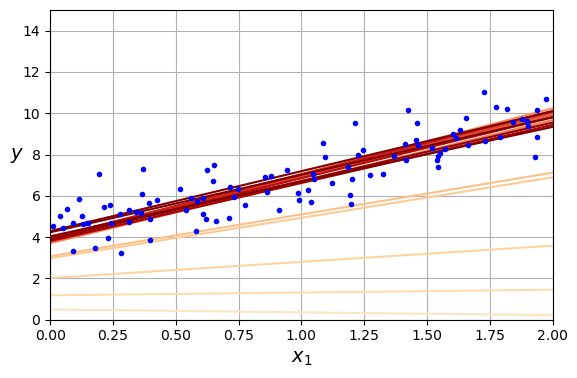

In [20]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1) # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):
        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)
            
        random_index = np.random.randint(m)
        # use [random_index:random_index+1] instead of [random_index] to keep the array type
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]   
        gradients = 2 * xi.T @ (xi @ theta - yi) # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta) # extra code – to generate the figure
        
# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("sgd_plot")
plt.show()  

While the batch GD code iterated 1000 times through the whole training set, this code goes through the training set only 50 times and reaches a pretty good solution:

In [21]:
theta

array([[4.21076011],
       [2.74856079]])

When using SGD, the training instances must be independent and identically distributed to ensure that the parameters get pulled toward the global optimum, on average. A simple way to ensure this is to **shuffle the instances during training** (e.g., pick each instance randomly, or shuffle the training set at the beginning of each epoch). 

In [22]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel()) # y.ravel() because fit() expects 1D targets

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

The `SGDRegressor` class defaults to optimising the MSE cost function.
The code runs for max 1000 epochs (`max_iter`) or until the loss drops by less than $10^{-5}$ (`tol`) during 100 epochs (`n_iter_no_change`). It starts with a learning rate of 0.01 (`eta0`), and using the default learning schedule (different from above).
`penalty=None` means no regularization.

In [23]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

### Mini-batch gradient descent

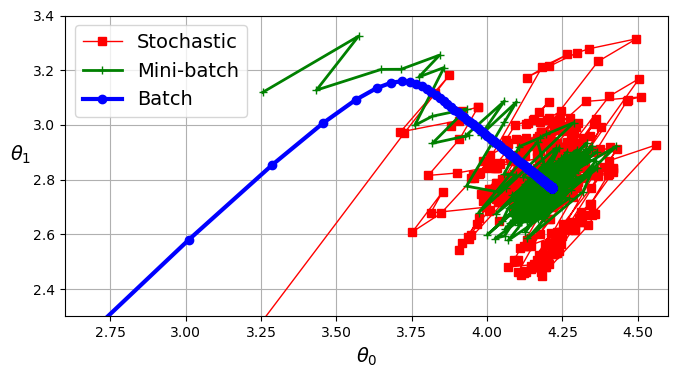

In [24]:
# extra code – this cell generates and saves Figure 4–11

from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

t0, t1 = 200, 1000  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx: idx + minibatch_size]
        yi = y_shuffled[idx: idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
        
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
save_fig("gradient_descent_paths_plot")
plt.show()

# Polynomial Regression

In [32]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3 # generates m numbers between -3 and 3
y = 0.7 * X**2 + X + 3 + np.random.randn(m,1)

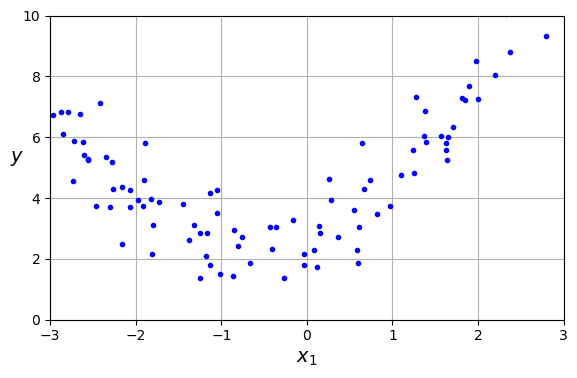

In [33]:
# extra code – this cell generates and saves Figure 4–12
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_data_plot")
plt.show()

In [34]:
from sklearn.preprocessing import PolynomialFeatures

# bias is the term independent of x (or features)
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [35]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` now contains the original feature of X plus the square of this feature.

In [36]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.78134581]), array([[0.93366893, 0.76456263]]))

Not bad, the model estimates $y = 0.76456263x^2 + 0.93366893x + 2.78134581$ when in fact the original function was $y = 0.7x^2 + x + 3$ + Gaussian noise.

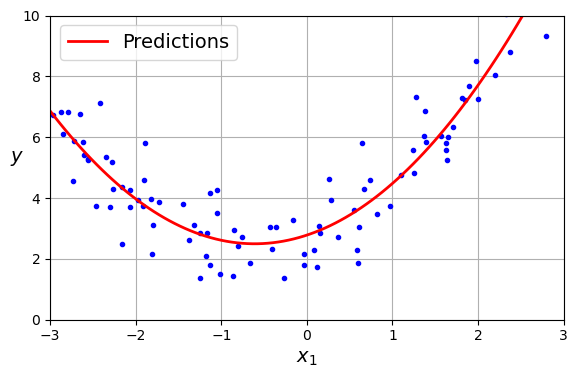

In [37]:
# extra code – this cell generates and saves Figure 4–13

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_predictions_plot")
plt.show()

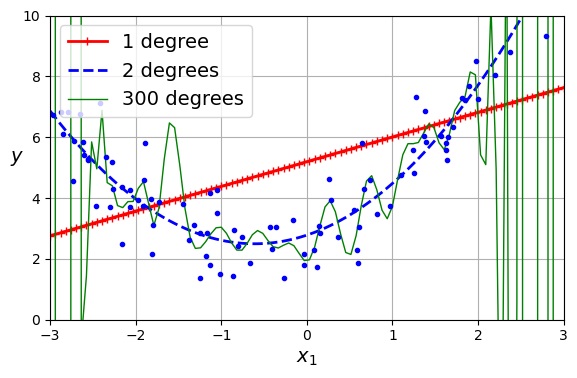

In [38]:
# extra code – this cell generates and saves Figure 4–14

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("high_degree_polynomials_plot")
plt.show()

The high-degree polynomial regression model is severely overfitting the training data, while the linear model is underfitting it. How can we tell that our model is overfitting or underfitting the data?

# Learning Curves

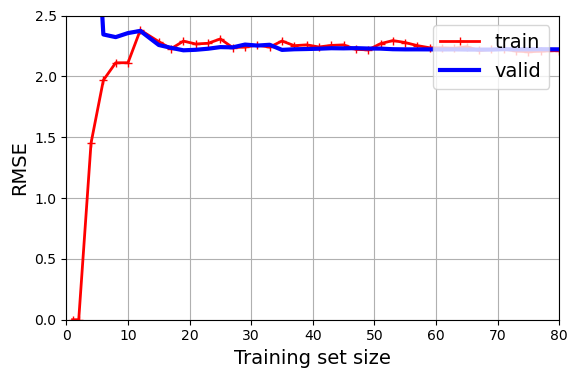

In [39]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
save_fig("underfitting_learning_curves_plot")

plt.show()

This model is underfitting, because both training and validation error is high. Both curves have reached a plateau; they are close and fairly high.
To fix underfitting, we need a better model or come up with better features.

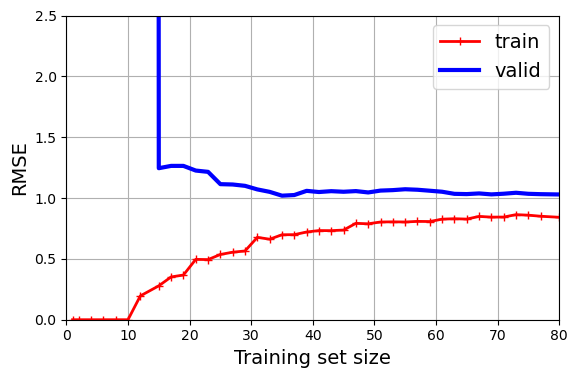

In [40]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
save_fig("learning_curves_plot")
plt.show()

This model is overfitting, because there is a gap between the curves. this means that the model performs significantly better on the training data than on the validation data.
To fix overfitting, one way is to feed it more training data until the validation error reaches the training error.
We can also use regularization to reduce overfitting.

# Regularized Linear Models
### Ridge Regression
Let's generate a very small and noisy linear dataset:

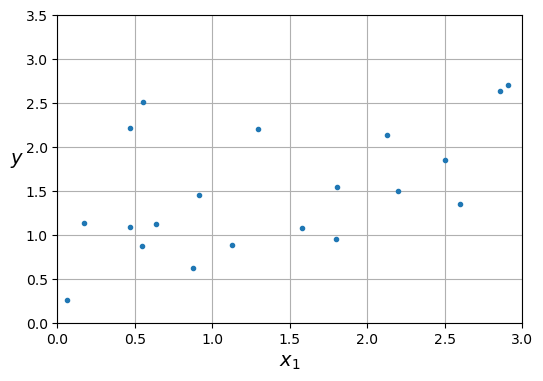

In [41]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

# extra code – a quick peek at the dataset we just generated
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [42]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

This performs ridge regression using a closed-form solution, which uses a matrix factorization technique by Cholesky.

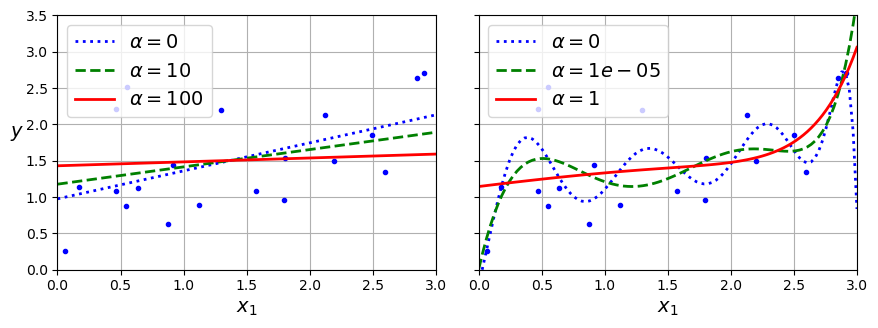

In [43]:
def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("ridge_regression_plot")
plt.show()

Linear (left) and polynomial (right) models, both with various levels of ridge regularization.
The higher the value of $\alpha$, the more regularized the model is.
We can use SGD to perform ridge regression as well:

In [44]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1/m, tol=None, 
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.55302613])

In [45]:
# extra code – show that we get roughly the same solution as earlier when
#              we use Stochastic Average GD (solver="sag")
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55326019]])

**NOTE**: We can use `RidgeCV` class to perform Ridge Regression, but it also automatically tunes hyperparameters using cross-validation. It's roughly equivalent to `GridSearchCV`, but it's optimised for ridge regression and runs much faster. Several other estimators also have efficient CV variants such as `LassoCV` and `ElasticNetCV`.

In [46]:
# extra code – shows the closed form solution of Ridge regression,
#              compare with the next Ridge model's learned parameters below
alpha = 0.1
# A is the identity matrix with 0 in the top left cell, to exclude the bias term
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[0.97898394],
       [0.3828496 ]])

In [47]:
ridge_reg.intercept_, ridge_reg.coef_

(array([0.97896386]), array([[0.38286422]]))

### Lasso Regression

In [48]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

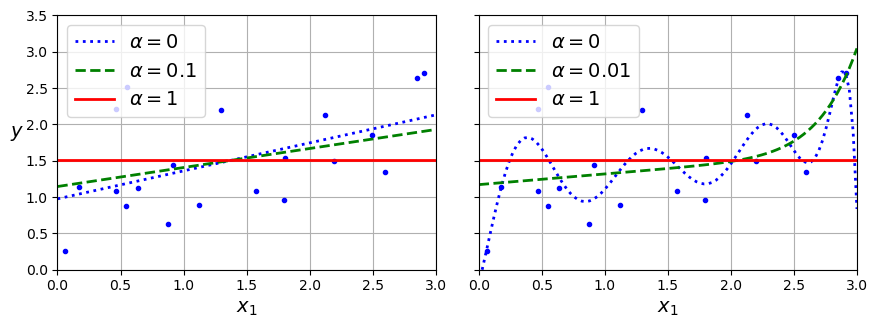

In [49]:
# extra code – this cell generates and saves Figure 4–18
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("lasso_regression_plot")
plt.show()

Linear (left) and polynomial (right) models, both with various levels of lasso regularization.
An important characteristic of lasso regression is that it tends to eliminate the weights of the least important features(i.e., set them to 0). For example , the green line in the righthand plt ($\alpha$ = 0.01) looks roughtly cubic: all the weights for the high-degree polynomial features are equal to 0. 
In other words, lasso regression automatically performs **feature selection**.

### Elastic Net

In [50]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

# Early Stopping

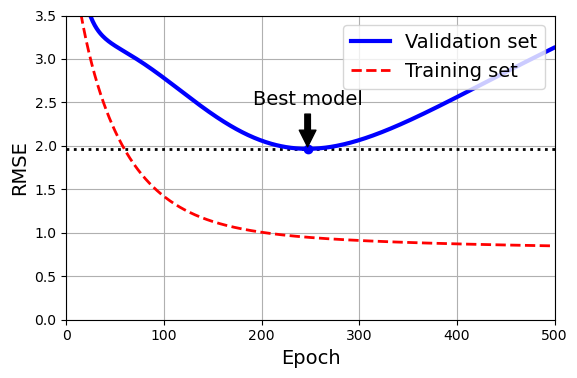

In [53]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.7 * X ** 2 + X + 3 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []

for epoch in range(n_epochs):
    # Incremental learning
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        # Note that deepcopy copies both the model's hyperparameters and the learned parameters
        # sklearn.base.clone() only copies the hyperparameters
        best_model = deepcopy(sgd_reg)
        
    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)
    
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
save_fig("early_stopping_plot")
plt.show()

# Logistic Regression
For binary classification
### Estimating Probabilities
Below is the logistic function $\sigma (t) = \dfrac{1}{1+e^{-t}}$

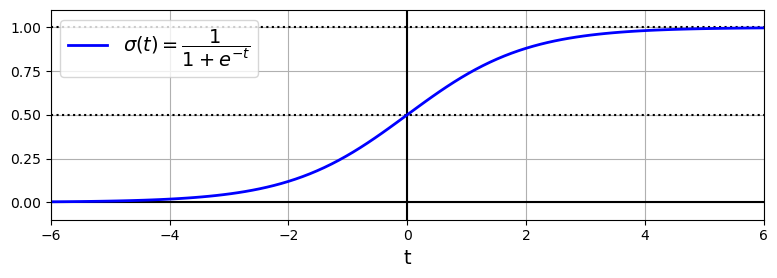

In [54]:
lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
save_fig("logistic_function_plot")
plt.show()

Probability > 0.5 when t > 0 (positive instance) \
Probability < 0.5 when t < 0 (negative instance)

### Decision Boundaries
Let's use the iris dataset to illustrate logistic regression. This is a dataset that contains the sepal and petal length and width of 150 iris flowers of 3 different species: *Iris setosa, Iris versecolor*, and *Iris virginica*

In [55]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [56]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [57]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [58]:
iris.target.head(3)

0    0
1    0
2    0
Name: target, dtype: int32

In [59]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

First, we try to build a classifier to detect the *Iris virginica* type based only on the petal width feature. 

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

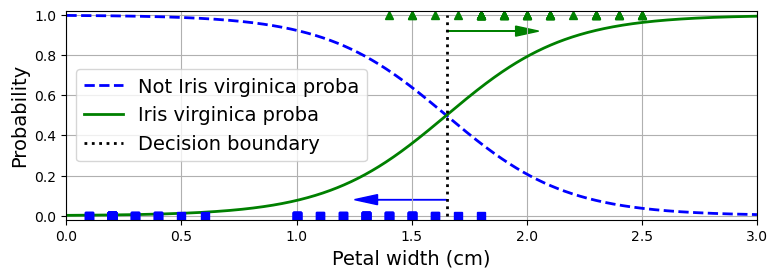

In [62]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1) # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
# out of all X values, select the first one that is predicted True 
# X is already sorted so the first X value is the smallest, so it is the decision boundary
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies and saves Figure 4–23
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
save_fig("logistic_regression_plot")

plt.show()

In [63]:
decision_boundary

1.6516516516516517

In [64]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

Now let's try predicting with 2 features!

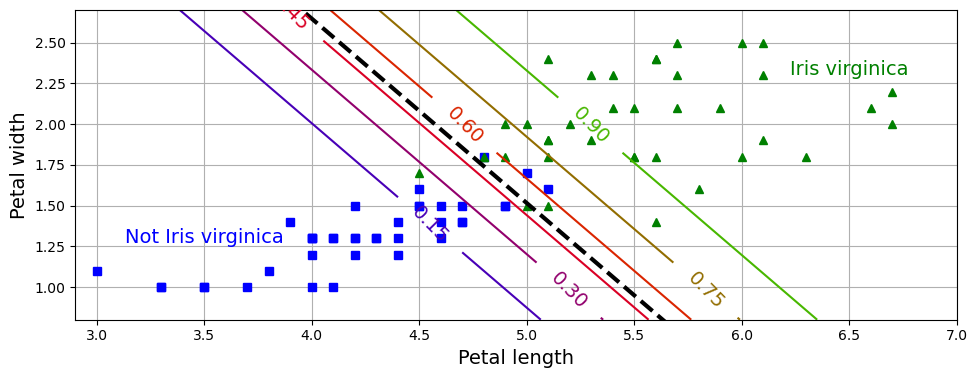

In [65]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# C is the hyperparameter controlling regularization strength
# The higher the value of C, the less the model is regularized
log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
# Translates slice objects to concatenation along the second axis. (zip)
# np.c_[np.array([1,2,3]), np.array([4,5,6])]
# output: array([[1, 4], [2, 5], [3, 6]])
# ravel() is equal to reshape(-1, order=order)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
save_fig("logistic_regression_contour_plot")
plt.show()

# Softmax Regression
The logistic regression model can be generalized to support multiple classes directly.

In [66]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [67]:
softmax_reg.predict([[5, 2]])

array([2])

In [68]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

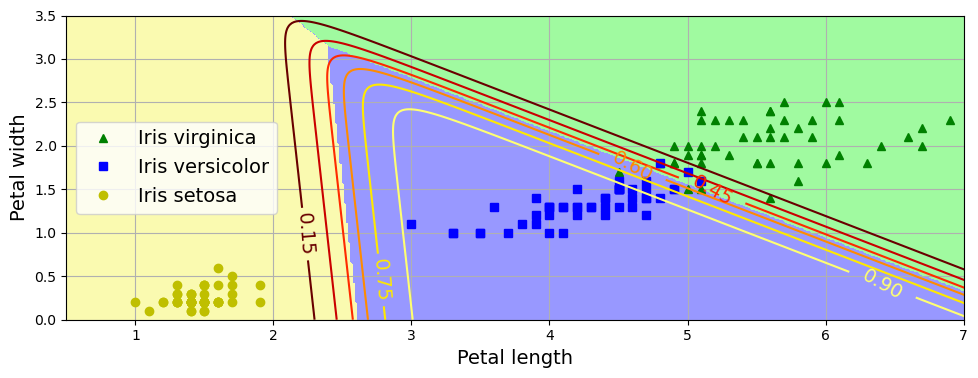

In [69]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("softmax_regression_contour_plot")
plt.show()

# Exercise
### 12. Batch Gradient Descent with early stopping for Softmax Regression
Exercise: *Implement Batch Gradient Descent with early stopping for Softmax Regression without using Scikit-Learn, only NumPy. Use it on a classification task such as the iris dataset.*

In [71]:
X = iris.data.values
y = iris.target.values

We need to add the bias term for every instance ($\theta_0 = 1$). Then we have to split the data into training, validation and test set manually.

In [72]:
X_with_bias = np.c_[np.ones(len(X)), X]
test_ratio = 0.2
val_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(test_ratio * total_size)
val_size = int(val_ratio * total_size)
train_size = total_size - test_size - val_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:(train_size + val_size)]]
X_test = X_with_bias[rnd_indices[(train_size + val_size):]]
y_train = y[rnd_indices[:train_size]]
y_valid = y[rnd_indices[train_size:(train_size + val_size)]]
y_test = y[rnd_indices[(train_size + val_size):]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for any given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance. To understand this code, you need to know that `np.diag(np.ones(n))` creates an n×n matrix full of 0s except for 1s on the main diagonal. Moreover, if a is a NumPy array, then `a[[1, 3, 2]]` returns an array with 3 rows equal to `a[1]`, `a[3]` and `a[2]`

In [73]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

# Example: y = [1,0,2,1]
# np.ones(y.max() + 1) = np.ones(2 + 1) = np.ones(3) = [1,1,1]
# np.diag(^that) = ([1, 0, 0],[0, 1, 0], [0, 0, 1])
# line3[y] = line3[[1,0,2,1]] = [0, 1, 0], [1, 0, 0], [0, 0, 1], [0, 1, 0]

Let's test this function on the first 10 instances:

In [74]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [75]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [76]:
y_train_oh = to_one_hot(y_train)
y_valid_oh = to_one_hot(y_valid)
y_test_oh = to_one_hot(y_test)

Now we scale the inputs (without using StandardScaler!). We compute the mean and std of each feature (except for bias), then we center and scale the training, validation and test set.

In [79]:
X_train[:5] # to remind myself of the shape

array([[1. , 6.1, 2.8, 4.7, 1.2],
       [1. , 5.7, 3.8, 1.7, 0.3],
       [1. , 7.7, 2.6, 6.9, 2.3],
       [1. , 6. , 2.9, 4.5, 1.5],
       [1. , 6.8, 2.8, 4.8, 1.4]])

In [80]:
# Select all rows, but exclude the bias column
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1].std(axis=0)

# fit() only on the training set, use that to transform all sets
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

In [81]:
X_train[:5]

array([[ 1.        ,  0.39652122, -0.38535161,  1.4311065 ,  0.10052651],
       [ 1.        , -0.10611131,  0.87122972, -2.33863746, -1.03039668],
       [ 1.        ,  2.40705133, -0.63666787,  4.19558541,  1.48276596],
       [ 1.        ,  0.27086308, -0.25969347,  1.17979024,  0.4775009 ],
       [ 1.        ,  1.27612814, -0.38535161,  1.55676464,  0.35184277]])

Now we implement the softmax function.
The formula is $\text{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$

In [82]:
# Takes in a 2D array, each row represents 1 instance, each column represent 1 class
# Each entry in input specifies the "score" of an instance for a class
# Returns a list of probabilities for each class
# Input shape (n, 3); Output shape (n,3)
def softmax(scores):
    exps = np.exp(scores)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums # Equal to [e / exp_sums for e in exps]

TRAINING TIMEEEE!
Note that $log(p^{(i)}_k)$ may not be computable if $p^{(i)}_k = 0$. So we will add a tiny value $\epsilon$ to $log(p^{(i)}_k)$ to avoid getting `nan` values.

In [85]:
n_inputs = X_train.shape[1] # == 5 (4 features plus the bias term)
n_outputs = len(np.unique(y_train)) # == 3 (there are 3 iris classes)

eta = 0.1
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
theta = np.random.rand(n_inputs, n_outputs)

for epoch in range(n_epochs):
    # X_train is nx5, theta is 5x3
    scores = X_train @ theta
    # y_proba is nx3
    y_proba = softmax(scores)
    # Compute validation loss every 1000 epochs
    if epoch % 1000 == 0:
        y_val_proba = softmax(X_valid @ theta)
        # both has dimensions nx3, so we need element wise multiplication
        val_error = y_valid_oh * np.log(y_val_proba + epsilon)
        val_error = -(val_error.sum(axis=1).mean())
        print(epoch, val_error)
    # X_train is n x 5,  y_proba - y_train_oh is nx3
    gradients = 1 / m * X_train.T @ (y_proba - y_train_oh)
    theta = theta - eta * gradients

0 1.9893636683154468
1000 0.1594894674135122
2000 0.13070743965554374
3000 0.11959104307770338
4000 0.1144776923713739
5000 0.11222176641497343


The model is trained! Let's look at the model parameters:

In [87]:
theta

array([[ 0.37674459,  5.35482142, -3.67431765],
       [-0.17623952,  1.00436139,  0.08254977],
       [ 1.71396571,  0.71859175, -0.90718269],
       [-3.32893086,  0.78217857,  4.24531922],
       [-0.81595376, -1.43704379,  3.47960427]])

Now let's measure the final model's accuracy on the test set:

In [88]:
y_pred_proba = softmax(X_valid @ theta)
y_predict = y_pred_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9666666666666667

For the sake of the exercise, let's add a bit of $l_2$ regularization.

In [92]:
alpha = 0.1

np.random.seed(42)
theta = np.random.rand(n_inputs, n_outputs)

for epoch in range(n_epochs):
    # X_train is nx5, theta is 5x3
    scores = X_train @ theta
    # y_proba is nx3
    y_proba = softmax(scores)
    # Compute validation loss every 1000 epochs
    if epoch % 1000 == 0:
        y_val_proba = softmax(X_valid @ theta)
        # Change the cost function
        val_error = y_valid_oh * np.log(y_val_proba + epsilon)
        # we omit the 1st element in theta because that's the bias term
        l2_loss = alpha / m * (theta[1:] ** 2).sum()
        val_error = -(val_error.sum(axis=1).mean()) + l2_loss
        print(epoch, val_error)
    # Change cost function gradient equation too
    gradients = 1 / m * X_train.T @ (y_proba - y_train_oh)
    # np.r_[arr1, arr2] concats arr1 and arr2 together into one 2D array
    # here arr1 is [[0,0,0]] to fill the bias terms, since we excluded it in regularization
    # arr2 has size 4x3 (theta with bias row removed)
    # so arr1 ++ arr2, we get a 5x3 array
    gradients += np.r_[np.zeros([1, n_outputs]), 2 * alpha * theta[1:] / m]
    theta = theta - eta * gradients

0 1.993514409149998
1000 0.1833758301069098
2000 0.1642222038662232
3000 0.15889420450535055
4000 0.15729655412217766
5000 0.1570359650171927


In [93]:
y_pred_proba = softmax(X_valid @ theta)
y_predict = y_pred_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9666666666666667

Now let's add early stopping.

In [94]:
C = 10 # regularization hyperparameter, equal to 1/alpha
n_epochs = 50001
best_loss = np.infty

np.random.seed(42)
theta = np.random.rand(n_inputs, n_outputs)

for epoch in range(n_epochs):
    # X_train is nx5, theta is 5x3
    scores = X_train @ theta
    # y_proba is nx3
    y_proba = softmax(scores)
    y_val_proba = softmax(X_valid @ theta)
    val_error = y_valid_oh * np.log(y_val_proba + epsilon)
    l2_loss = (1 / (C * m)) * (theta[1:] ** 2).sum()
    val_error = -(val_error.sum(axis=1).mean()) + l2_loss
    if epoch % 1000 == 0:
        print(epoch, val_error)
    if val_error < best_loss:
        best_loss = val_error
    else:
        # Stop training
        print(epoch-1, best_loss.round(4))
        print(epoch, val_error.round(4), "early stopping!")
        break
    gradients = 1 / m * X_train.T @ (y_proba - y_train_oh)
    gradients += np.r_[np.zeros([1, n_outputs]), 2 / C * theta[1:] / m]
    theta = theta - eta * gradients

0 1.993514409149998
1000 0.1833758301069098
2000 0.1642222038662232
3000 0.15889420450535055
4000 0.15729655412217766
4848 0.157
4849 0.157 early stopping!


In [95]:
y_pred_proba = softmax(X_valid @ theta)
y_predict = y_pred_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9666666666666667

Finally, let's measure the final model's accuracy on the test set:

In [99]:
y_pred_proba = softmax(X_test @ theta)
y_predict = y_pred_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score 

1.0

Perhaps because the dataset is small, we somehow got 100% accuracy on the test set.